In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import lightgbm as lgb

In [32]:
train = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')

In [33]:
train['stock_id']                 = train['stock_id'].astype(np.uint8);
train['date_id']                  = train['date_id'].astype(np.uint16);
train['seconds_in_bucket']        = train['seconds_in_bucket'].astype(np.uint16);
train['imbalance_buy_sell_flag']  = train['imbalance_buy_sell_flag'].astype(np.int8);
train['reference_price']          = train['reference_price'].astype(np.float32);
train['far_price']                = train['far_price'].astype(np.float32);
train['near_price']               = train['near_price'].astype(np.float32);
train['bid_price']                = train['bid_price'].astype(np.float32);
train['ask_price']                = train['ask_price'].astype(np.float32);
train['wap']                      = train['wap'].astype(np.float32);
train['time_id']                  = train['time_id'].astype(np.uint16);

# Assessing the impact of the change on information loss:
cols = train.iloc[0:10].select_dtypes(np.number).columns;

In [34]:
# Create a boolean mask for the conditions
condition_1 = (train["seconds_in_bucket"] >= 0) & (train["seconds_in_bucket"] <= 300)
condition_2 = (train["seconds_in_bucket"] > 300) & (train["seconds_in_bucket"] <= 480)
condition_3 = (train["seconds_in_bucket"] > 480) & (train["seconds_in_bucket"] <= 540)

# Apply the conditions and assign values to the "ending" column
train.loc[condition_1, "ending"] = 1
train.loc[condition_2, "ending"] = 2
train.loc[condition_3, "ending"] = 3
train.loc[~(condition_1 | condition_2 | condition_3), "ending"] = 0

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Print max values and length of the DataFrame
# print(max(train["date_id"]))
# print(max(train["seconds_in_bucket"]))
# print(len(train))

# Drop rows with missing values
collapsed_data = train.dropna()
collapsed_data = collapsed_data.dropna()
# Select only numeric columns
numeric_columns = collapsed_data.select_dtypes(include=['float64', 'int64']).columns

# Group by 'stock_id' and calculate the mean for each group
aggregated_data = collapsed_data.groupby('stock_id')[numeric_columns].mean()

Index(['imbalance_size', 'matched_size', 'bid_size', 'ask_size', 'target',
       'ending'],
      dtype='object')


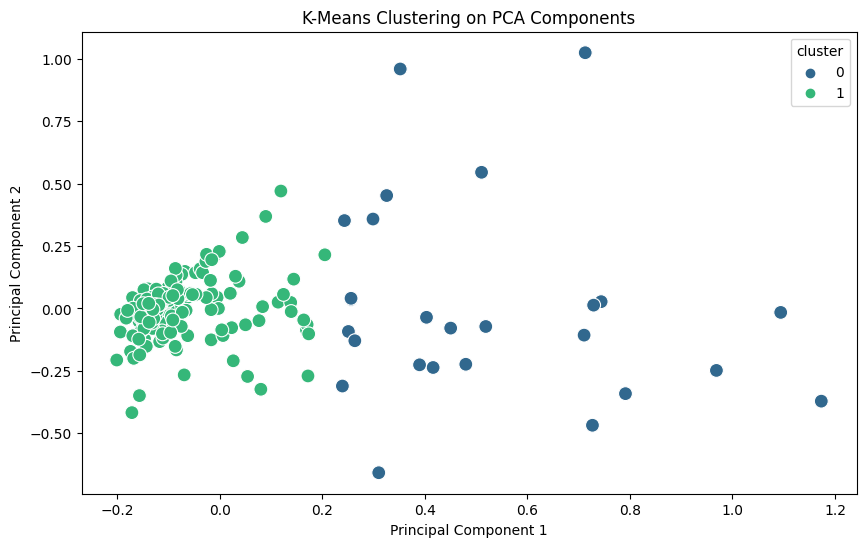

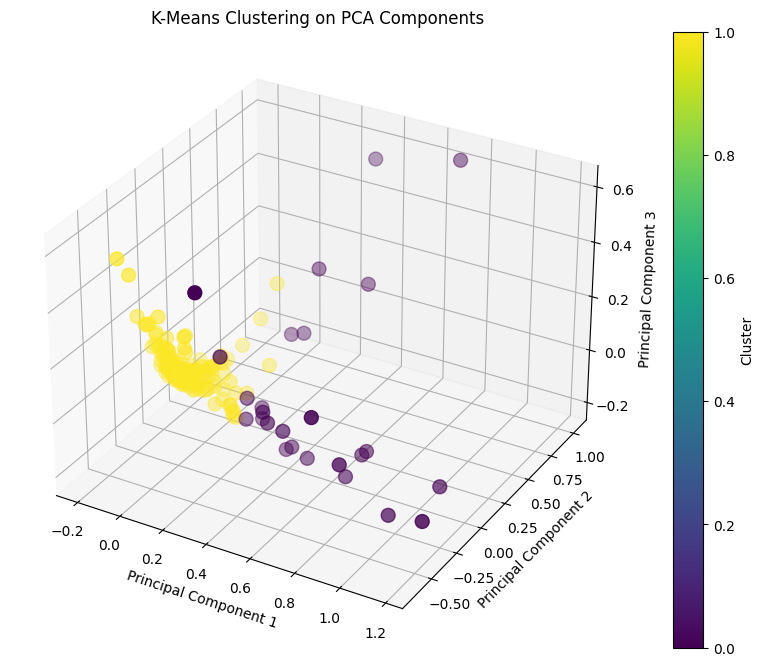

In [35]:
#aggregated_data = aggregated_data.drop(columns=['date_id', 'seconds_in_bucket', 'imbalance_buy_sell_flag', 'reference_price', 'bid_price', 'time_id'])

# before standardization
print(aggregated_data.columns)

# all columns but the stock_id should be standardized
columns_to_standardize = [col for col in aggregated_data.columns if col != 'stock_id']

# scaling
scaler = MinMaxScaler()

aggregated_data[columns_to_standardize] = scaler.fit_transform(aggregated_data[columns_to_standardize])

# Exclude 'stock_id' and 'target' columns
columns_to_cluster = aggregated_data.drop(columns=['target']).columns

# Perform k-means clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)  # Explicitly set n_init to suppress the warning
aggregated_data['cluster'] = kmeans.fit_predict(aggregated_data[columns_to_cluster])

# Perform PCA excluding 'stock_id' and 'target'
pca = PCA(n_components=3)
pca_result = pca.fit_transform(aggregated_data[columns_to_cluster])

# Add PCA components to DataFrame
aggregated_data['pca_1'] = pca_result[:, 0]
aggregated_data['pca_2'] = pca_result[:, 1]
aggregated_data['pca_3'] = pca_result[:, 2]

# Visualize clustering in 2D for PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster', data=aggregated_data, palette='viridis', s=100)
plt.title('K-Means Clustering on PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


# Visualize clustering in 3D for PCA components (PC1, PC2, PC3)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for PC1, PC2, and PC3
scatter = ax.scatter(aggregated_data['pca_1'], aggregated_data['pca_2'], aggregated_data['pca_3'], c=aggregated_data['cluster'], cmap='viridis', s=100)

# Set labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('K-Means Clustering on PCA Components')

# Add color bar
fig.colorbar(scatter, ax=ax, label='Cluster')

# Show the plot
plt.show()

In [36]:
  # Assuming 'aggregated_data' is the name of your DataFrame
  # Replace 'aggregated_data' with the actual name of your DataFrame
  aggregated_data_dict = dict(zip(aggregated_data.index, aggregated_data["cluster"]))
  # index_value = 124  # Replace with the actual index value you're interested in
  # cluster_value = aggregated_data_dict.get(index_value)
  # print(cluster_value)

In [37]:
train['cluster'] = train['stock_id']

In [38]:
train['cluster'] = train['cluster'].map(lambda x: aggregated_data_dict[x])

In [39]:
#Add lag features
features = ['imbalance_buy_sell_flag','imbalance_size','reference_price','matched_size','far_price','near_price','bid_size','bid_price','ask_size','ask_price','wap','target']
windows = [3,5]
for feature in features:
    for w in windows:
        train[f'{feature}_{w}_mavg'] = train.groupby('stock_id')[feature].transform(lambda x: x.rolling(window=w).mean())
        train[f'{feature}_{w}_shift'] = train.groupby('stock_id')[feature].shift(w)
        train[f'{feature}_{w}_percent_change'] = train.groupby('stock_id')[feature].pct_change(periods=w) * 100

In [40]:
cols_exclude = ["target", 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', "matched_size", 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', "ask_size", 'wap', "row_id"]
cols_to_use = [col for col in train.columns if col not in cols_exclude]

In [41]:
train = train.dropna()

In [42]:
X_train = train[cols_to_use][train['time_id'] <= 21163]
Y_train = train["target"][train['time_id'] <= 21163]

X_test = train[cols_to_use][train['time_id'] > 21163]
Y_test = train["target"][train['time_id'] > 21163]

In [43]:
categoricals = ['stock_id', 'date_id', 'ending', 'cluster', 'seconds_in_bucket']

In [44]:
model = lgb.LGBMRegressor(
     boosting_type='gbdt', 
     num_leaves=31, 
     max_depth=-1, 
     learning_rate=0.1, 
     n_estimators=100, 
     subsample_for_bin=200000, 
     objective='mae', 
     class_weight=None, 
     min_split_gain=0.0, 
     min_child_weight=0.001, 
     min_child_samples=20, 
     subsample=1.0, 
     subsample_freq=0, 
     colsample_bytree=1.0, 
     reg_alpha=0.0, 
     reg_lambda=0.0,  
     n_jobs=-1, 
     importance_type='split',
     force_row_wise=True)


In [45]:
model.fit(X_train, Y_train)

LGBMRegressor(force_row_wise=True, objective='mae')

In [46]:
import optiver2023

env = optiver2023.make_env()
iter_test = env.iter_test()
counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
     sample_prediction['target'] = model.predict(test.drop('row_id', axis = 1))
     env.predict(sample_prediction)
     counter += 1

Exception: You can only call `make_env()` once.